In [19]:
### Author: Leonie Küchenhoff
### Date: December 7 2022
### Purpose of script: 
### Import potnetial off-target sites (found by cas-offinder) & export bam file with regions of interest
### Theses regions of interest wiill be examined more closely with reditools

In [20]:
# package import
import pandas as pd
from config import basedir, outdir, cas_offinder
from matplotlib import pyplot as plt
import seaborn as sns

In [7]:
# sample names
names = ['028_pbs_R', '029_pbs_R', '032_pbs_R','033_nrch_R', '030_nrch_R', '036_nrch_R', 
            '011_pbs', '012_nrch', '013_nrch', '014_nrch', '279_spry', '321_pbs', '333_pbs', '450_spry', '283_spry']
# treatment in same order as sample names
base_editor = ['pbs', 'pbs','pbs','8e-NRCH', '8e-NRCH', '8e-NRCH',
            'pbs', '8e-NRCH', '8e-NRCH','8e-NRCH', 'max-SpRY', 'pbs', 'pbs', 'max-SpRY', 'max-SpRY']
outdir = f'{outdir}/offinder'

In [9]:
# read cas offinder results
spry = pd.read_csv(f'{cas_offinder}/off_target_spry.txt', header = None, delimiter='\t', names = ['gRNA', 'chr', 'pos', 'seq', 'dir','mismatches'])
nrch = pd.read_csv(f'{cas_offinder}/off_target_nrch.txt', header = None, delimiter='\t', names = ['gRNA', 'chr', 'pos', 'seq', 'dir','mismatches'])

In [10]:
# for each sequence similarity start site, extract area around it
nrch.loc[:,'start'] = nrch.loc[:,'pos'] - 10
nrch.loc[:,'stop'] = nrch.loc[:,'pos'] + 30

spry.loc[:,'start'] = spry.loc[:,'pos'] - 10
spry.loc[:,'stop'] = spry.loc[:,'pos'] + 30

In [11]:
# gRNA seqeuences
nrch_p = nrch[nrch['gRNA'] == 'GAACGTAGCCGCTCTGGACCANNNN']
nrch_r = nrch[nrch['gRNA'] == 'GCACAGTCTCGAAGTCCAATGNNNN']

In [12]:
# create bed files with sequence similarity regions to gRNA
nrch_p[['chr', 'start', 'stop']].to_csv(f'{cas_offinder}/off_target_nrch_p.bed', sep= '\t', header = None, index = None)
nrch_r[['chr', 'start', 'stop']].to_csv(f'{cas_offinder}/off_target_nrch_r.bed', sep= '\t', header = None, index = None)
spry[['chr', 'start', 'stop']].to_csv(f'{cas_offinder}/off_target_spry.bed', sep= '\t', header = None, index = None)

In [13]:
# exclude target area
nrch_p = nrch_p[~(nrch_p['pos']>=53843221)& (nrch_p['pos']<=53843268) & (nrch_p['chr']>='chr19')]
nrch_r = nrch_r[~(nrch_r['pos']>=53843221)& (nrch_r['pos']<=53843268) & (nrch_r['chr']>='chr19')]
spry = spry[~(spry['pos']>=53843221)& (spry['pos']<=53843268) & (spry['chr']>='chr19')]

In [14]:
# group by number of mismatches to plot data
mm_nrch_r = nrch_r.groupby('mismatches', dropna = False).count()['gRNA'].rename('R363Q \n 8e-NRCH')
mm_nrch_p = nrch_p.groupby('mismatches').count()['gRNA'].rename('P635L \n 8e-NRCH')
mm_spry = spry.groupby('mismatches').count()['gRNA'].rename('P635L \n max-SpRY')

In [15]:
mismatchcount = pd.DataFrame({'mismatches':[0,1,2,3,4,5]})

In [16]:
#merge with dataframe to have consistent format
plot = mismatchcount.merge(mm_nrch_r, on = 'mismatches', how = 'left')\
    .merge(mm_nrch_p, on = 'mismatches', how = 'left')\
    .merge(mm_spry, on = 'mismatches', how = 'left')\
    .fillna(0)\
    .melt(id_vars = 'mismatches')

In [17]:
# Plotting settings
plt.rcParams.update({'font.size':20, 'text.usetex': False,
"svg.fonttype": 'none'})
colors = ['orange',
          'steelblue',
          'navy'
          ]
costum_palette = sns.color_palette(colors)

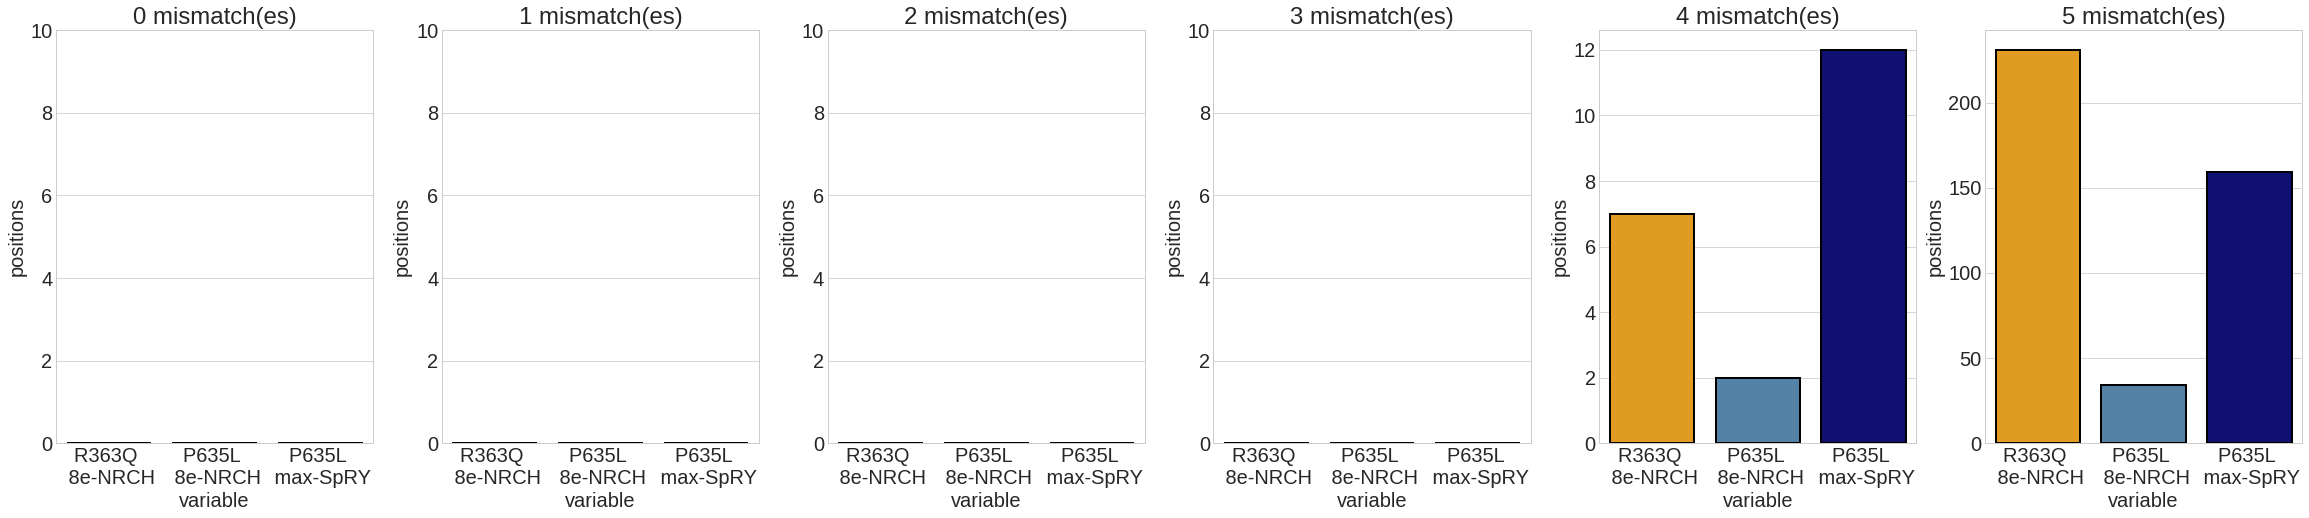

In [21]:
fig, ax  = plt.subplots(1,6, figsize = (32,7))
plt.style.use('seaborn-colorblind')
plt.style.use('seaborn-whitegrid')

for i in range(6):
    sns.barplot(x = 'variable', y = 'value', data = plot[plot['mismatches'] == i], ax = ax[i],palette = costum_palette, edgecolor = 'black', linewidth = 2)
    ax[i].set_title(f'{i} mismatch(es)')
    ax[i].set_ylabel('positions')


ax[0].set_ylim(0,10)
ax[1].set_ylim(0,10)
ax[2].set_ylim(0,10)
ax[3].set_ylim(0,10)

fig.tight_layout(pad = 0.01)
fig.show()
fig.savefig(f'{outdir}/positions_mismatches.pdf', bbox_inches = 'tight')
fig.savefig(f'{outdir}/positions_mismatches.svg', bbox_inches = 'tight')

In [22]:
plot.to_csv(f'{outdir}/mismatches.txt')